In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [14]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from typing import Annotated
from typing_extensions import TypedDict
import operator
from pydantic import BaseModel
from IPython.display import Image

# LLM setup
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [5]:
subtopics_prompt = """List 3 unique and engaging subtopics related to the main theme: {theme}."""

fact_prompt = """Share one fun and surprising fact about the following subtopic: {subtopic}."""

best_fact_prompt = """You are given several fun facts about the theme: {theme}.
Choose the most interesting fun fact and return ONLY its index (starting from 0).

Facts:
{facts}
"""


In [6]:
class Subtopics(BaseModel):
    subtopics: list[str]

class BestFact(BaseModel):
    id: int

class OverallState(TypedDict):
    theme: str
    subtopics: list
    facts: Annotated[list, operator.add]
    best_fact: str

In [10]:
def generate_subtopics(state: OverallState):
    prompt = subtopics_prompt.format(theme=state["theme"])
    response = model.with_structured_output(Subtopics).invoke(prompt)
    return {"subtopics": response.subtopics}

def continue_to_facts(state: OverallState):
    return [Send("generate_fact", {"subtopic": s}) for s in state["subtopics"]]

class FactState(TypedDict):
    subtopic: str

class Fact(BaseModel):
    fact: str

def generate_fact(state: FactState):
    prompt = fact_prompt.format(subtopic=state["subtopic"])
    response = model.with_structured_output(Fact).invoke(prompt)
    return {"facts": [response.fact]}

In [11]:
def choose_best_fact(state: OverallState):
    facts = "\n\n".join(state["facts"])
    prompt = best_fact_prompt.format(theme=state["theme"], facts=facts)
    response = model.with_structured_output(BestFact).invoke(prompt)
    return {"best_fact": state["facts"][response.id]}

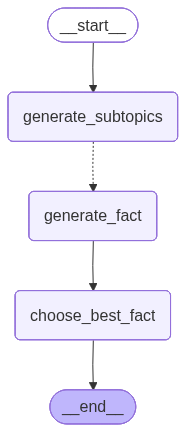

In [15]:
graph = StateGraph(OverallState)
graph.add_node("generate_subtopics", generate_subtopics)
graph.add_node("generate_fact", generate_fact)
graph.add_node("choose_best_fact", choose_best_fact)
graph.add_edge(START, "generate_subtopics")
graph.add_conditional_edges("generate_subtopics", continue_to_facts, ["generate_fact"])
graph.add_edge("generate_fact", "choose_best_fact")
graph.add_edge("choose_best_fact", END)

app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [16]:
for step in app.stream({"theme": "wedding exploration"}):
    print(step)

{'generate_subtopics': {'subtopics': ["**1. Cultural Wedding Traditions Around the World**  \nExplore the diverse and fascinating wedding customs from different cultures and countries. From the vibrant and colorful Indian weddings to the serene and symbolic Japanese ceremonies, delve into the unique rituals, attire, and traditions that make each culture's wedding celebrations special.\n\n**2. Eco-Friendly and Sustainable Wedding Planning**  \nDiscover how couples are embracing sustainability in their wedding planning. Learn about eco-friendly venues, zero-waste decorations, and sustainable catering options. Explore how to incorporate green practices into every aspect of a wedding, from invitations to the honeymoon, without compromising on style or elegance.\n\n**3. The Evolution of Wedding Fashion: From Vintage to Modern**  \nTrace the history of wedding fashion and how it has evolved over the decades. Examine the influence of historical events, cultural shifts, and fashion icons on br